In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install -q kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "virajbagal"
os.environ['KAGGLE_KEY'] = "668ae848051438ff559726906387dd6d"

In [0]:
!kaggle datasets download -d virajbagal/chestxray14-256x256

100% 3.66G/3.66G [01:07<00:00, 43.8MB/s]



In [0]:
print(os.listdir('/content'))

In [0]:
!unzip /content/chestxray14-256x256.zip

Streaming output truncated to the last 5000 lines.
  inflating: 00028897_015.png        
  inflating: 00028897_016.png        
  inflating: 00028897_017.png        
  inflating: 00028897_018.png        
  inflating: 00028897_019.png        
  inflating: 00028897_020.png        
  inflating: 00028898_000.png        
  inflating: 00028899_000.png        
  inflating: 00028899_001.png        
  inflating: 00028899_002.png        
  inflating: 00028900_000.png        
  inflating: 00028901_000.png        
  inflating: 00028901_001.png        
  inflating: 00028902_000.png        
  inflating: 00028902_001.png        
  inflating: 00028902_002.png        
  inflating: 00028902_003.png        
  inflating: 00028902_004.png        
  inflating: 00028902_005.png        
  inflating: 00028902_006.png        
  inflating: 00028902_007.png        
  inflating: 00028902_008.png        
  inflating: 00028903_000.png        
  inflating: 00028903_001.png        
  inflating: 00028903_002.png        

In [0]:
import numpy as np
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
import ast

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tfm
from torchvision import models
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import MSELoss
import torch
import random
from torch import nn

plt.style.use('default')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
EPOCHS = 20
DEBUG = False
RESUME = False
LR = 1e-4
WD = 1e-5
PAT = 5
FACTOR = 0.1
BS = 16
NUM_CLASSES = 14
# SIZE = 256
CROP_SIZE = 128
SEED = 42
if DEBUG:
    EPOCHS = 1

DIR = '/content/gdrive/My Drive/ChestXray14/'

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
 
seed_everything(SEED)

In [0]:
invalid = pd.read_csv(DIR+'invalid.txt', sep=' ', header=None)
invalid_list = []

invalid_list.append(ast.literal_eval(invalid.values[0][0][1:-1]).split('/')[-1])
for i in range(518):
  invalid_list.append(ast.literal_eval(invalid.values[0][i+1][:-1]).split('/')[-1])  

In [0]:
train_idx = np.concatenate(pd.read_csv(DIR+'train_val_list.txt', sep=' ', header=None).values)
test_idx = np.concatenate(pd.read_csv(DIR+'test_list.txt', sep=' ', header=None).values)

all_xray_df = pd.read_csv(DIR+'Data_Entry_2017_v2020.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/content','*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,/content/00022260_003.png
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,64,M,AP,2500,2048,0.168,0.168,/content/00012048_007.png
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,/content/00014352_005.png


In [0]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
13396,00003489_002.png,,0,3489,49,M,PA,2500,2048,0.171,0.171,/content/00003489_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78570,00019271_053.png,Atelectasis,53,19271,54,M,AP,2500,2048,0.168,0.168,/content/00019271_053.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66807,00016508_048.png,,48,16508,51,F,AP,2500,2048,0.168,0.168,/content/00016508_048.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
class ChestDataset(Dataset):
    def __init__(self, df, transform, mode='train'):
        self.label_df = df[all_labels].values
        self.path_df = df['path'].values
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.path_df)
    
    def __getitem__(self, idx):
        path = self.path_df[idx]
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
        if self.mode=='val':
          img = cv2.resize(img, (CROP_SIZE, CROP_SIZE))

        
        if self.transform:
            img = self.transform(img)
            

        label = self.label_df[idx]
            

        return img, torch.tensor(label, dtype=torch.float)

In [0]:
train_tfm = tfm.Compose([tfm.ToPILImage(),
                         tfm.RandomCrop(CROP_SIZE),
                         tfm.RandomHorizontalFlip(),
                         tfm.RandomVerticalFlip(),
                         tfm.ToTensor()])

val_tfm = tfm.Compose([tfm.ToPILImage(),
                       tfm.ToTensor()])

In [0]:
all_xray_df = all_xray_df[~all_xray_df['Image Index'].isin(invalid_list)].reset_index(drop=True)
train_valdf = all_xray_df[all_xray_df['Image Index'].isin(train_idx)].reset_index(drop=True)
valdf = train_valdf.sample(n=10000, random_state=SEED)
traindf = train_valdf[~train_valdf['Image Index'].isin(list(valdf['Image Index'].values))]
testdf = all_xray_df[all_xray_df['Image Index'].isin(test_idx)].reset_index(drop=True)

In [0]:
train_dataset = ChestDataset(traindf, train_tfm)
val_dataset = ChestDataset(valdf, val_tfm, mode='val')
test_dataset = ChestDataset(testdf, test_tfm, mode='test')

trainloader = DataLoader(train_dataset, batch_size=BS, num_workers=4, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BS, num_workers=4, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BS, num_workers=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

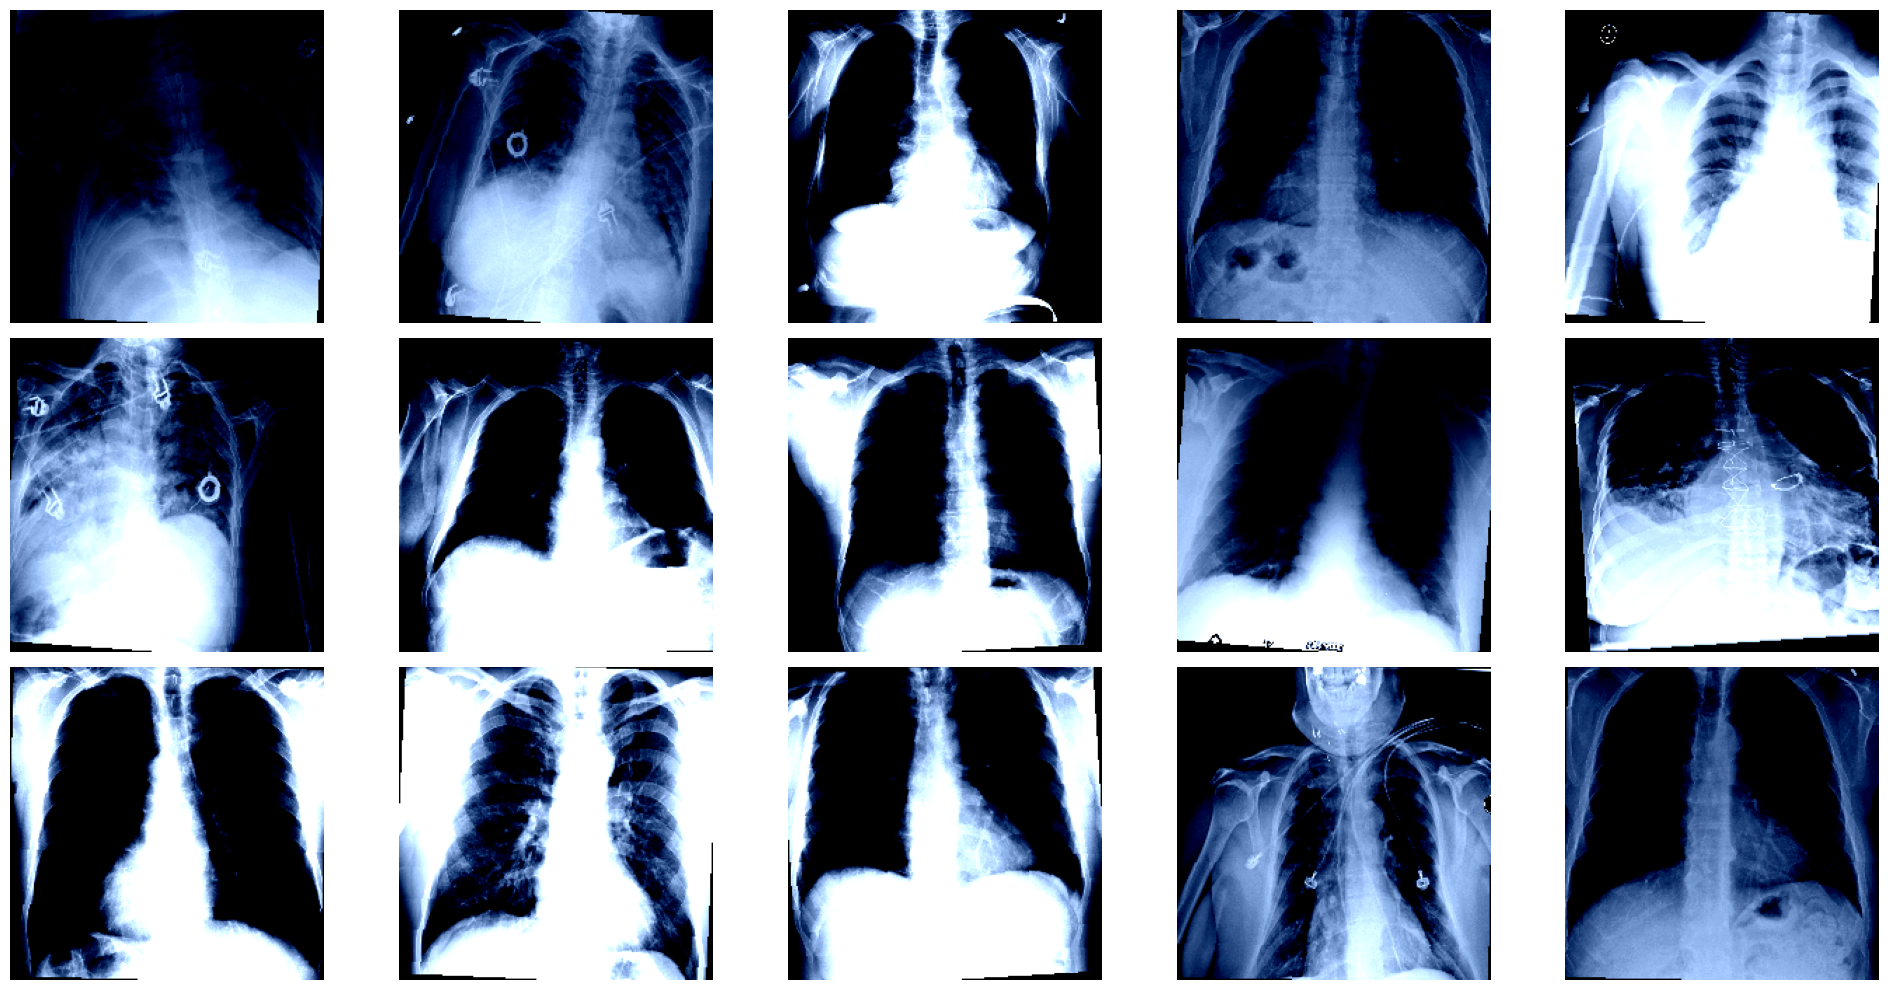

In [0]:
plt.figure(figsize=(20,10))

for i in range(15):
    plt.subplot(3,5,i+1)
    idx = np.random.randint(len(trainloader))
    img, _ = train_dataset[idx]
    plt.imshow(img.numpy().transpose(1,2,0), cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [0]:
class Autoencoder(nn.Module):

    def __init__(self):
        super (Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            #1x896x896
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, stride = 4, padding = 2),
            nn.ELU(),
            #1X224X224
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0),
            #1x224x224
            )

        self.decoder = nn.Sequential(
            #1x224x224
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(4),
            #1x896x896
            )
        
        

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        x = Relu1.apply(x)
        
        return x


class Relu1(Function):

    @staticmethod
    def forward(ctx, input):

        ctx.save_for_backward(input)
        #print("fwd:", input[0])
        return input.clamp(min=0, max=1)

    @staticmethod
    def backward(ctx, grad_output):

        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input<0]*=0.0
        grad_input[input>1]*=0.0

        return grad_input

In [0]:
model = Autoencoder()

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = WD)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=PAT, factor = FACTOR, mode='min') # Reduce lr by 0.1 factor after every 5 epochs
criterion = MSELoss()

def get_lr(optimizer):
  lr_list = []
  for p in optimizer.param_groups:
    lr_list.append(p['lr'])

  return lr_list[0]

In [0]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_one_epoch(epoch, dataloader, model, criterion, optimizer, scheduler):
  train_loss = 0
  length = len(dataloader)
  model.train()
  optimizer.zero_grad()
  iterator = tqdm(enumerate(dataloader), total=length, leave=False, desc=f'Epoch {epoch+1}/{EPOCHS}')

  for i, (img, _) in iterator:
    img = img.to(device)
    
    output = model(img)
    
    loss = criterion(output, img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_loss += loss.item()/length


    if DEBUG:
      if i==100:
        break

    if scheduler:
      scheduler.step()

  return train_loss

def validate_one_epoch(epoch, dataloader, model, criterion):
  val_loss = 0
  length = len(dataloader)
  model.eval()
  iterator = tqdm(enumerate(dataloader), total=length, leave=False, desc=f'Epoch {epoch+1}/{EPOCHS}')

  for i, (img, _) in iterator:
    img = img.to(device)

    output = model(img)

    loss = criterion(output,img)
    val_loss += loss.item()/length
    
    if DEBUG:
      if i==100:
        break

  return val_loss

In [0]:
best_loss = np.inf
best_auc = 0

model.to(device)

for epoch in range(EPOCHS):
  if RESUME:
    epoch = resume_epoch + 1

  t_loss = train_one_epoch(epoch, trainloader, model, criterion, optimizer, scheduler=None)
  lr = get_lr(optimizer)
  print('Epoch {}/{} (train) || Loss: {:.4f} LR: {:.5f}'.format(epoch+1, EPOCHS, t_loss, lr))
    
  v_loss = validate_one_epoch(epoch, valloader, model, criterion)
  print('Epoch {}/{} (validation) || Loss: {:.4f} '.format(epoch+1, EPOCHS, v_loss)

  scheduler.step(v_loss)  


  content = 'Train Loss: {:.4f} Val Loss: {:.4f}'.format(t_loss, v_loss)

  recorder={}

  recorder['epoch'] = epoch
  recorder['model'] = model.state_dict()
  recorder['optimizer'] = optimizer.state_dict()
  recorder['scheduler'] = scheduler.state_dict()

  torch.save(recorder, DIR+'chestxray14_ae_recorder.pth')

  with open(DIR+'chestxray14_ae.txt', 'a') as logger:
    logger.write(content + '\n')

  if v_loss<best_loss:
    torch.save(model.state_dict(), DIR+'chestxray14_ae_loss.pth')
    best_loss = v_loss

Epoch 1/20 (train) || Loss: 0.1462 AUC: 0.7504 LR: 0.00010


Epoch 1/20 (validation) || Loss: 0.1380 AUC: 0.7981


Epoch 2/20 (train) || Loss: 0.1362 AUC: 0.8023 LR: 0.00010


Epoch 2/20 (validation) || Loss: 0.1348 AUC: 0.8115


Epoch 3/20 (train) || Loss: 0.1334 AUC: 0.8200 LR: 0.00010


Epoch 3/20 (validation) || Loss: 0.1359 AUC: 0.8127


Epoch 4/20 (train) || Loss: 0.1314 AUC: 0.8306 LR: 0.00010


Epoch 4/20 (validation) || Loss: 0.1343 AUC: 0.8265


Epoch 5/20 (train) || Loss: 0.1302 AUC: 0.8351 LR: 0.00010


Epoch 5/20 (validation) || Loss: 0.1344 AUC: 0.8222


Epoch 6/20 (train) || Loss: 0.1288 AUC: 0.8428 LR: 0.00010


Epoch 6/20 (validation) || Loss: 0.1344 AUC: 0.8239


Epoch 7/20 (train) || Loss: 0.1276 AUC: 0.8477 LR: 0.00010


Epoch 7/20 (validation) || Loss: 0.1319 AUC: 0.8331


Epoch 8/20 (train) || Loss: 0.1266 AUC: 0.8518 LR: 0.00010


Epoch 8/20 (validation) || Loss: 0.1318 AUC: 0.8296


Epoch 9/20 (train) || Loss: 0.1255 AUC: 0.8558 LR: 0.00010


Epoch 9/20 (validation) || Loss: 0.1317 AUC: 0.8319


Epoch 10/20 (train) || Loss: 0.1245 AUC: 0.8596 LR: 0.00010


Epoch 10/20 (validation) || Loss: 0.1317 AUC: 0.8313


Epoch 11/20 (train) || Loss: 0.1237 AUC: 0.8639 LR: 0.00010


Epoch 11/20 (validation) || Loss: 0.1320 AUC: 0.8367


Epoch 12/20 (train) || Loss: 0.1225 AUC: 0.8675 LR: 0.00010


Epoch 12/20 (validation) || Loss: 0.1327 AUC: 0.8338


Epoch 13/20 (train) || Loss: 0.1214 AUC: 0.8708 LR: 0.00010


Epoch 13/20 (validation) || Loss: 0.1330 AUC: 0.8309


Epoch 14/20 (train) || Loss: 0.1205 AUC: 0.8746 LR: 0.00010


Epoch 14/20 (validation) || Loss: 0.1329 AUC: 0.8349


Epoch 15/20 (train) || Loss: 0.1196 AUC: 0.8778 LR: 0.00010


Epoch 15/20 (validation) || Loss: 0.1335 AUC: 0.8323


Epoch 16/20 (train) || Loss: 0.1118 AUC: 0.9008 LR: 0.00001


Epoch 16/20 (validation) || Loss: 0.1321 AUC: 0.8360


Epoch 17/20 (train) || Loss: 0.1086 AUC: 0.9085 LR: 0.00001


Epoch 17/20 (validation) || Loss: 0.1341 AUC: 0.8354


Epoch 18/20 (train) || Loss: 0.1069 AUC: 0.9132 LR: 0.00001


Epoch 18/20 (validation) || Loss: 0.1349 AUC: 0.8320


Epoch 19/20 (train) || Loss: 0.1054 AUC: 0.9156 LR: 0.00001


Epoch 19/20 (validation) || Loss: 0.1354 AUC: 0.8321


Epoch 20/20 (train) || Loss: 0.1040 AUC: 0.9192 LR: 0.00001


Epoch 20/20 (validation) || Loss: 0.1378 AUC: 0.8302
